In [1]:
import requests as re
from bs4 import BeautifulSoup
from csv import writer
from datetime import date, timedelta
import pandas as pd
import numpy as np
import warnings
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})


InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

pd.set_option('display.width', 1000000)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)


fund_id_map = {
    'AXIS': 53,
    'CANARA': 32,
    'MIRAE': 45,
    'PPFAS': 64,
    'QUANT': 13,
    'ICICI': 20,
#     'MOTI': 55,
#     'UTI': 28,
    'NIPPON': 21,
    'SBI': 22,
} 

fund_scheme_map = {    
    'AXIS': { 
        'axis_long_term_equity': 120503,
        'axis_small_cap': 125354,
#         'axis_mid_cap': 120505,
#         'axis_flexi_cap': 141925,        
#         'axis_bluechip': 120465
    },
    'CANARA': {
        'canara_emerging_equities': 118278,
        'canara_small_cap': 146130,
        'canara_bluchip': 118269,
        'canara_tax_saver': 118285
    },
    'MIRAE': {
        'mirae_tax_saver': 135781,
        'mirae_emerging_bluchip': 118834,
        'mirae_large_cap': 107578
    },
    'PPFAS': {
        'ppfas_flexi_cap': 122639
    },
    'QUANT': {
        'quant_active_fund': 120823,
        'quant_small_cap': 120828
    },
    'ICICI': {
        'icici_value_discovery': 120323
    },
#     'MOTI': {
#         'moti_nifty_200_momentum': 149800
#     },
#     'UTI': {
#         'uti_midcap_quality_50': 150313
#     },
    'NIPPON': {
#         'nippon_alpha_low_volatility': 150487,
        'nippon_value_fund': 118784
    },
    'SBI': {
        'sbi_small_cap': 125497,
        'sbi_large_and_mid': 119721,
        'sbi_bluechip': 119598
    }
}



In [2]:

st_dt = date(2016, 1, 1)
en_dt = st_dt.replace(year=st_dt.year +4)



def fetch_and_write():
    for fund, mfID in fund_id_map.items():
        for scheme ,scID in fund_scheme_map[fund].items():
            
            start_dt = st_dt
            end_dt = en_dt
            
            while start_dt < date.today():
                resp = fetch(mfID, scID, start_dt, end_dt)            
                soup = BeautifulSoup(resp.content)            
                
                start_dt = end_dt + timedelta(days =1)
                end_dt = end_dt.replace(year = end_dt.year +4)
                
                
                for child in soup.find_all('tbody')[0].find_all('tr'):
                    td_list = child.find_all('td')

                    if(len(td_list) !=4 ):
                       continue

                    x = [td_list[3].string, td_list[0].string]
                    with open("{}.csv".format(scheme), 'a') as f_object:
                        writer_object = writer(f_object)
                        writer_object.writerow(x)
                        f_object.close()                                                
                
            
def fetch(mfID, scID, sDate, eDate):
    url = 'https://www.amfiindia.com/modules/NavHistoryPeriod'    
    
    data = {
      'mfID': mfID,
      'scID': scID,
      'fDate': sDate.strftime('%d-%b-%Y'),
      'tDate': eDate.strftime('%d-%b-%Y'),
    }

    return re.post(url = url, data =data)
    

fetch_and_write()


In [13]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

out = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']);

final_df = pd.DataFrame()

def multi_period_return(period_returns):
 return np.prod(period_returns + 1) - 1

for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():
        df = pd.read_csv('{}.csv'.format(scheme), names= ['date', 'nav'], parse_dates=['date'], index_col = ['date'])
        df['nav'] = df['nav']/df['nav'].max()
        pr = df.pct_change()
  
        df['1yr_roll_ret'] = pr.rolling('360D').apply(multi_period_return).mul(100)
        df['2yr_roll_ret'] = pr.rolling('720D').apply(multi_period_return).mul(100)
        df['3yr_roll_ret'] = pr.rolling('1080D').apply(multi_period_return).mul(100)
        df['5yr_roll_ret'] = pr.rolling('1800D').apply(multi_period_return).mul(100)
        df['cum_return']   = pr.add(1).cumprod().sub(1).mul(100)
        df['fund']=scheme
        final_df = pd.concat([final_df, df])
        
        
#         out.loc[scheme] = df['1yr_roll_ret'].iloc[245:].describe().values

final_df = final_df.iloc[1:,:].reset_index()

In [14]:
durations = [
#     '1yr_roll_ret', '2yr_roll_ret', 
    '3yr_roll_ret', '5yr_roll_ret']

dates     = [
#     '04-01-2016','04-01-2018',
    '04-01-2019','04-01-2021']

tax_free_rates = [ 
#     7, 14.49,
    22.05, 40.26]   # @7  %

desired_rates = [
#     14, 29.96, 
    48.15, 92.54  ] # @14 %


In [23]:
for idx, ret in enumerate(durations):
    ans = pd.DataFrame()
    for fund, mfID in fund_id_map.items():
        for scheme ,scID in fund_scheme_map[fund].items():
    #         data = final_df[final_df['fund'] == scheme]['1yr_roll_ret'].describe()

    #         data['1yr_roll_ret'] = final_df[final_df['fund'] == scheme]['1yr_roll_ret'].describe()
    #         data['2yr_roll_ret'] = final_df[final_df['fund'] == scheme]['2yr_roll_ret'].describe()
    #         data['3yr_roll_ret'] = final_df[final_df['fund'] == scheme]['3yr_roll_ret'].describe()        
    #         data['fund'] = scheme        
              data = final_df[ (final_df['fund'] == scheme) & (final_df['date'] >= dates[idx]) ][ret].describe()
    #         print(data.transpose())
              data['fund'] = scheme

              ans = ans.append(data.transpose())
    #           
    print(f"return for duration: {ret}")
    ans = ans.reset_index()
    ans = ans.set_index(['fund','index'])
    ans = ans.loc[:, ~ans.columns.isin(['count'])]
    print(ans[['min','max','25%','mean','50%','75%','std']].sort_values(by=['min','std'], ascending=[False, True] ))
    print("")


return for duration: 3yr_roll_ret
                                          min      max     25%    mean     50%      75%     std
fund                     index                                                                 
axis_long_term_equity    3yr_roll_ret   2.731  108.597  33.585  46.815  47.322   58.622  20.783
ppfas_flexi_cap          3yr_roll_ret   1.563  134.375  42.700  65.559  51.998   89.718  31.606
canara_bluchip           3yr_roll_ret  -0.145  107.181  34.156  53.409  55.454   67.148  22.392
axis_small_cap           3yr_roll_ret  -1.035  160.409  33.376  71.193  55.653  113.405  46.170
canara_tax_saver         3yr_roll_ret  -3.528  118.700  33.697  56.519  54.110   79.178  28.134
mirae_tax_saver          3yr_roll_ret  -6.359  119.107  38.061  59.842  67.273   78.905  28.844
sbi_small_cap            3yr_roll_ret  -6.952  138.238  22.376  63.209  53.821  106.887  43.256
mirae_emerging_bluchip   3yr_roll_ret  -9.631  127.125  33.440  59.156  63.565   81.836  32.079
canara

Probability of return greater than risk free: axis_long_term_equity : 3yr_roll_ret : 0.47


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: axis_small_cap : 3yr_roll_ret : 0.58


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_emerging_equities : 3yr_roll_ret : 0.52


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_small_cap : 3yr_roll_ret : 0.48


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_bluchip : 3yr_roll_ret : 0.62


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_tax_saver : 3yr_roll_ret : 0.59


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: mirae_tax_saver : 3yr_roll_ret : 0.68


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: mirae_emerging_bluchip : 3yr_roll_ret : 0.64


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: mirae_large_cap : 3yr_roll_ret : 0.4


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: ppfas_flexi_cap : 3yr_roll_ret : 0.62


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: quant_active_fund : 3yr_roll_ret : 0.57


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: quant_small_cap : 3yr_roll_ret : 0.5


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: icici_value_discovery : 3yr_roll_ret : 0.39


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: nippon_value_fund : 3yr_roll_ret : 0.42


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: sbi_small_cap : 3yr_roll_ret : 0.57


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: sbi_large_and_mid : 3yr_roll_ret : 0.43


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: sbi_bluechip : 3yr_roll_ret : 0.34


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: axis_long_term_equity : 5yr_roll_ret : 0.62


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: axis_small_cap : 5yr_roll_ret : 1.0


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_emerging_equities : 5yr_roll_ret : 0.71


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_small_cap : 5yr_roll_ret : 0.88


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_bluchip : 5yr_roll_ret : 0.88


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: canara_tax_saver : 5yr_roll_ret : 0.97


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: mirae_tax_saver : 5yr_roll_ret : 0.95


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: mirae_emerging_bluchip : 5yr_roll_ret : 0.91


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: mirae_large_cap : 5yr_roll_ret : 0.51


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: ppfas_flexi_cap : 5yr_roll_ret : 1.0


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: quant_active_fund : 5yr_roll_ret : 1.0


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: quant_small_cap : 5yr_roll_ret : 0.99


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: icici_value_discovery : 5yr_roll_ret : 0.54


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: nippon_value_fund : 5yr_roll_ret : 0.6


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: sbi_small_cap : 5yr_roll_ret : 0.97


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: sbi_large_and_mid : 5yr_roll_ret : 0.69


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

Probability of return greater than risk free: sbi_bluechip : 5yr_roll_ret : 0.27


[Text(0.5, 0, 'Uniform Distribution'), Text(0, 0.5, 'Frequency')]

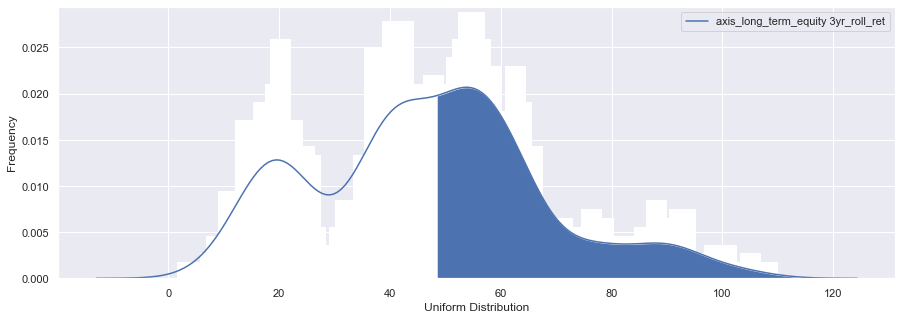

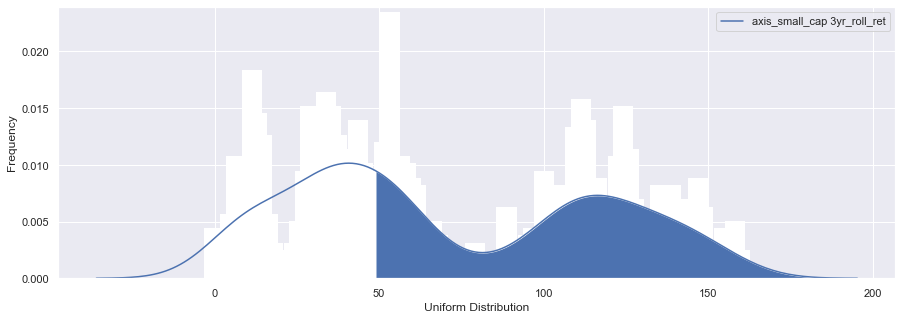

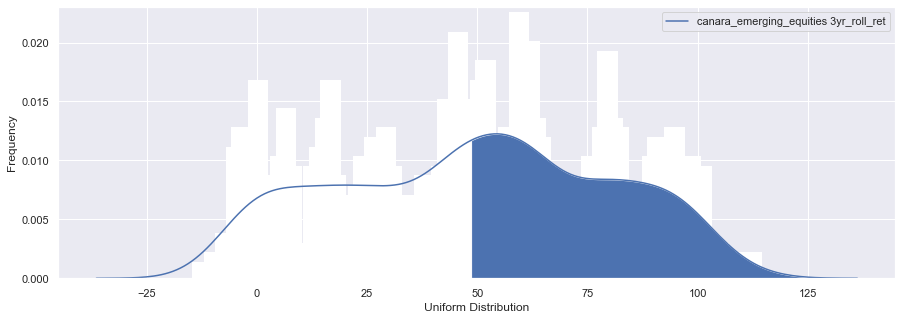

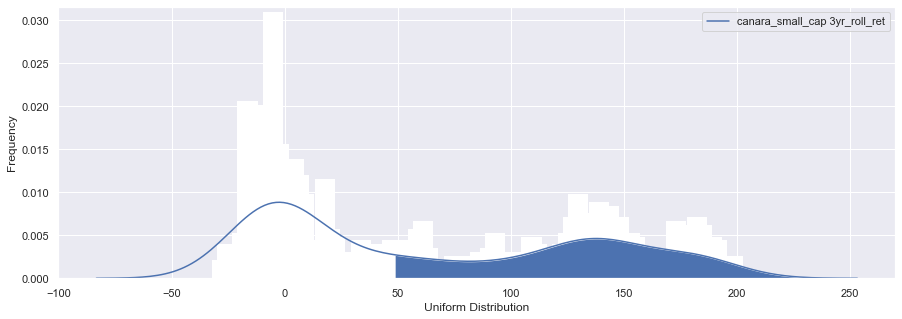

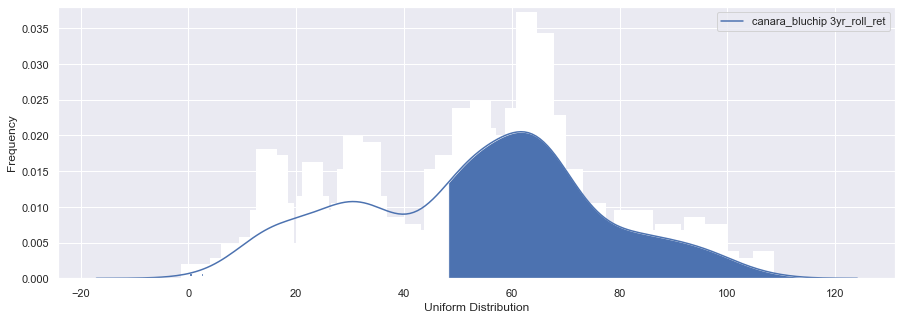

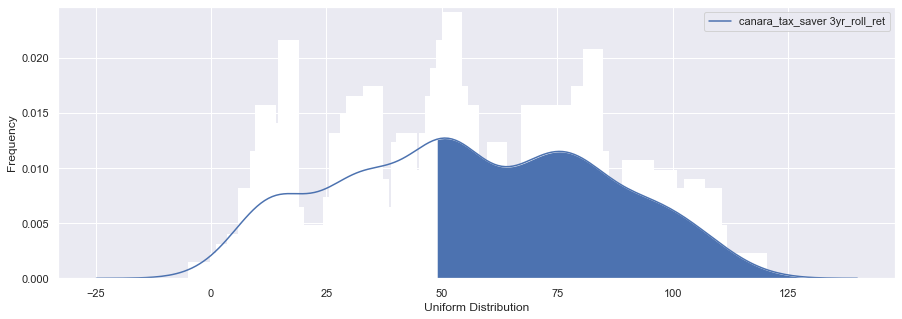

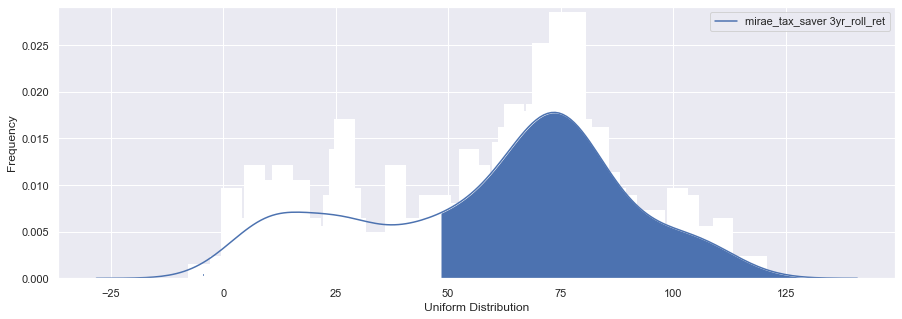

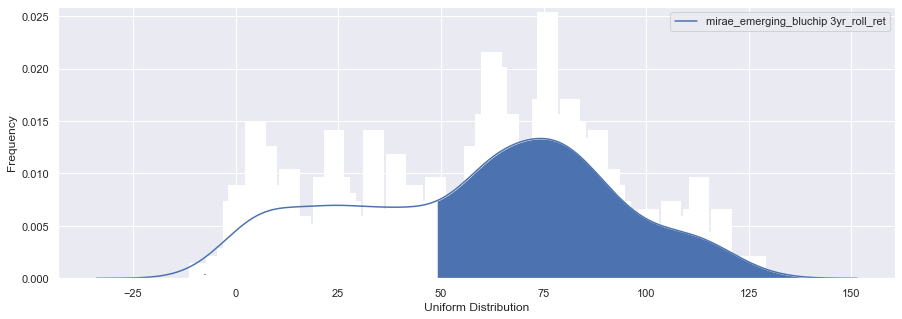

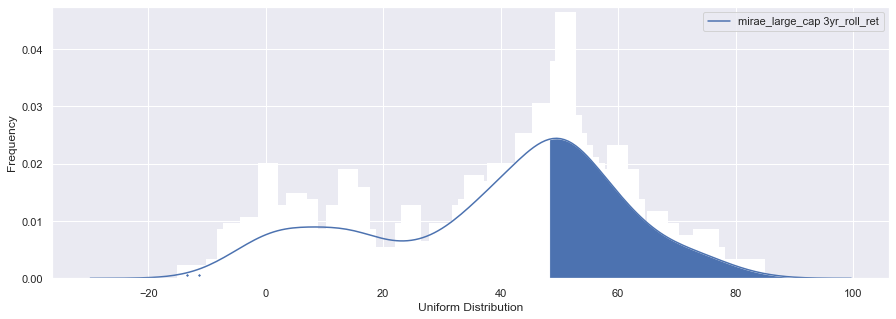

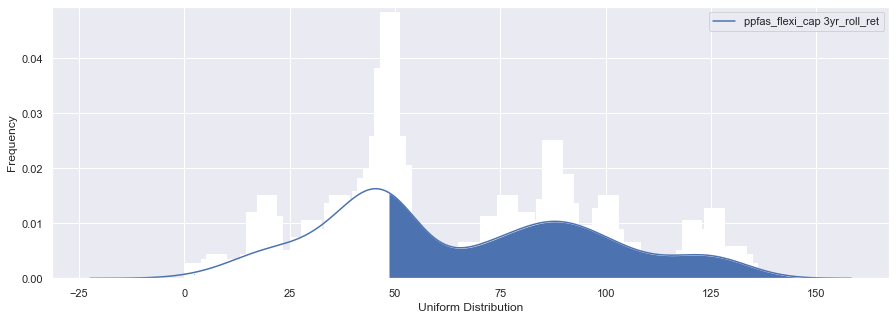

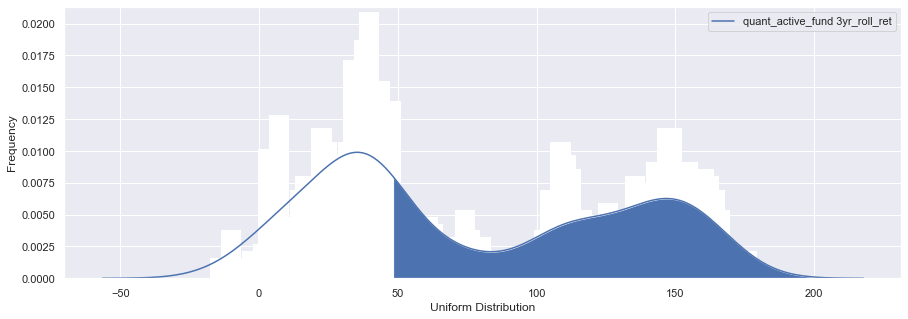

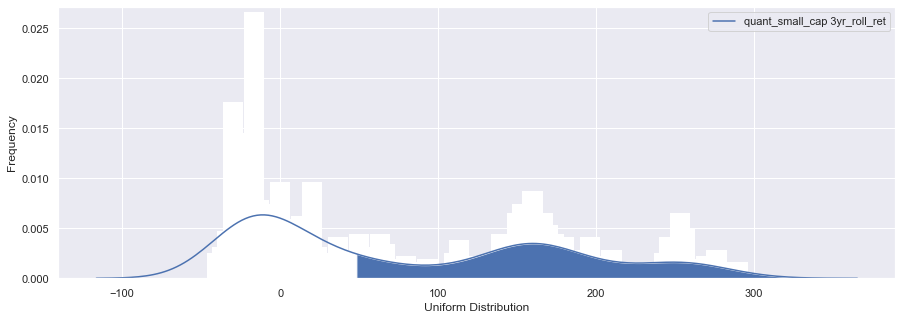

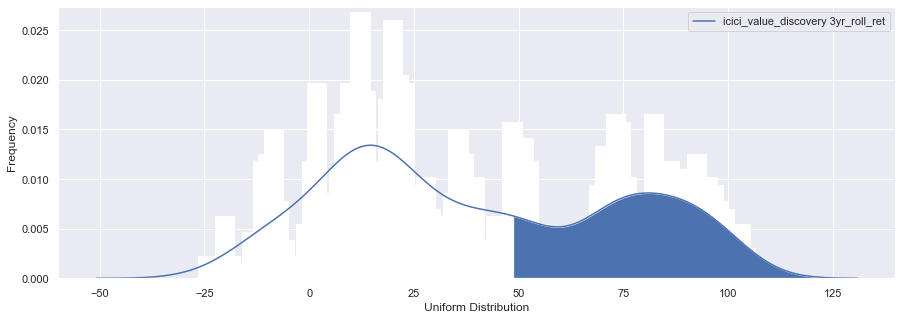

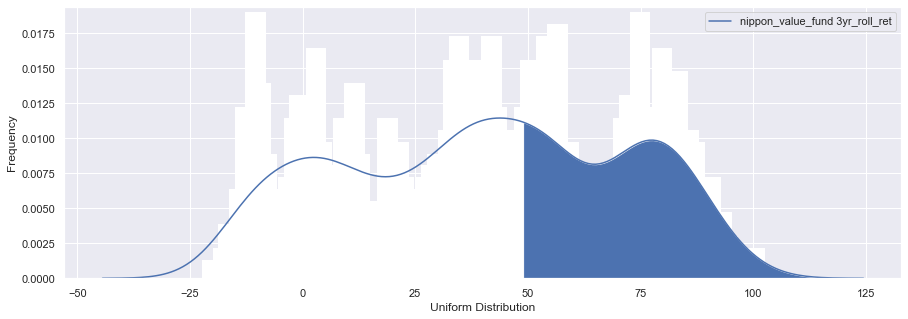

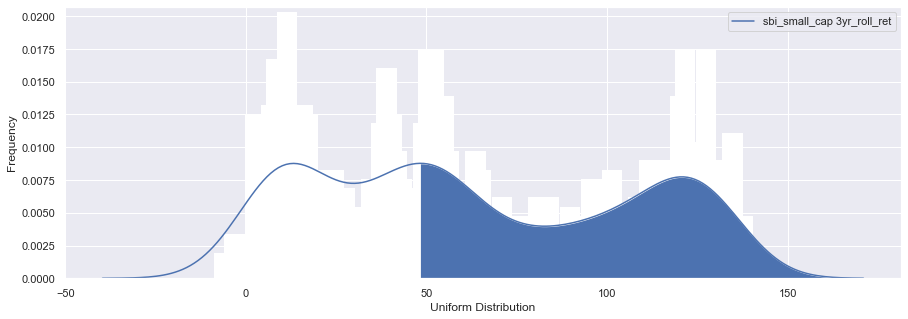

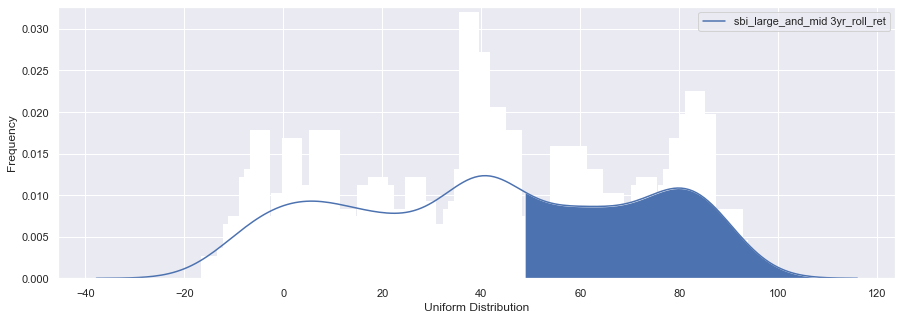

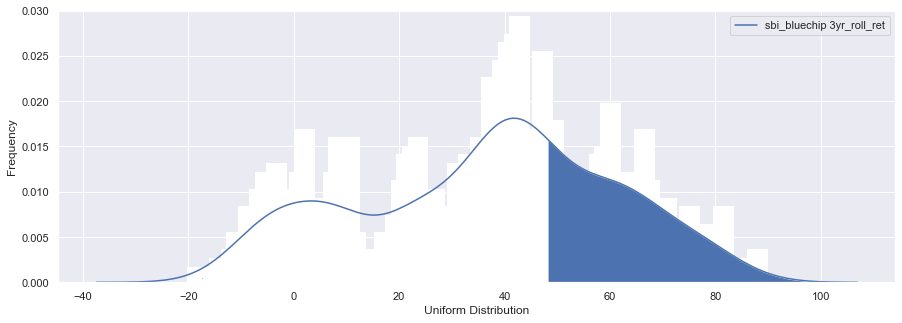

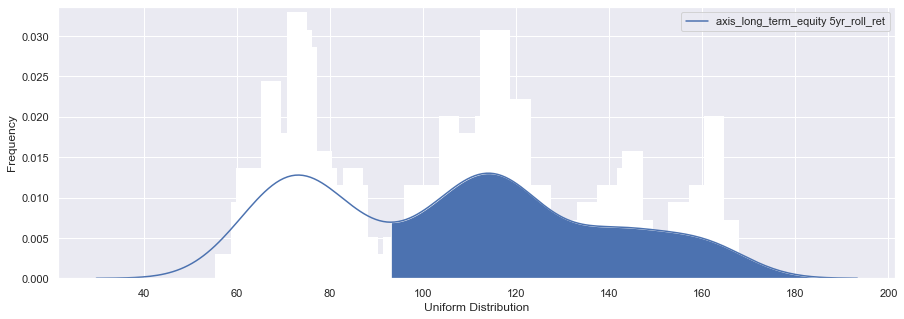

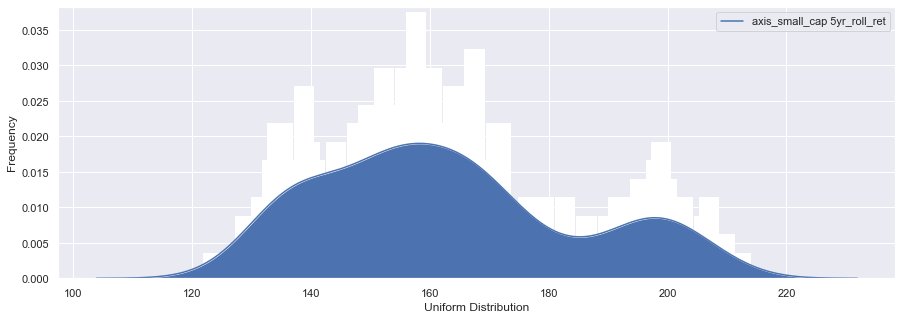

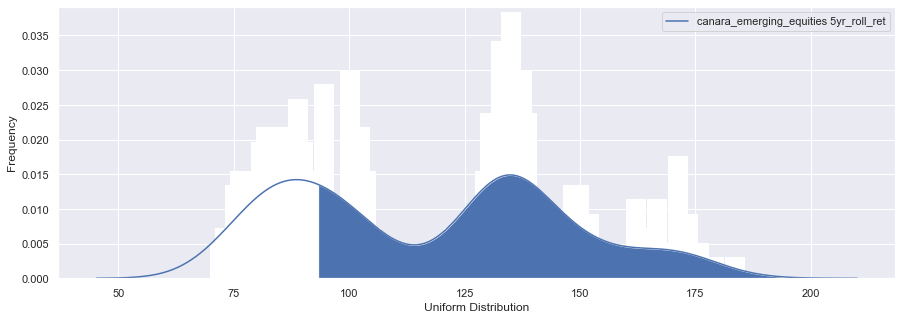

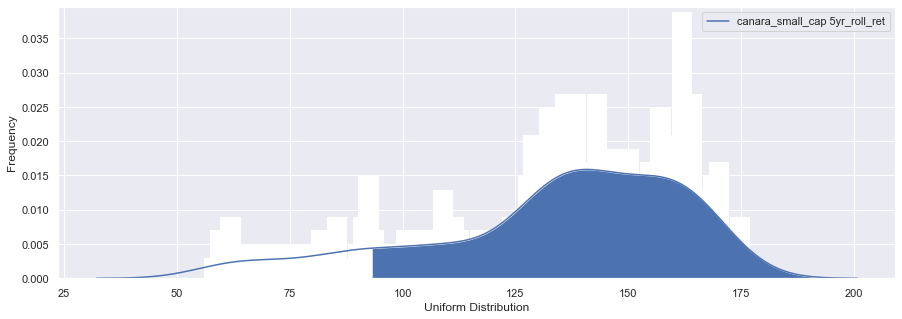

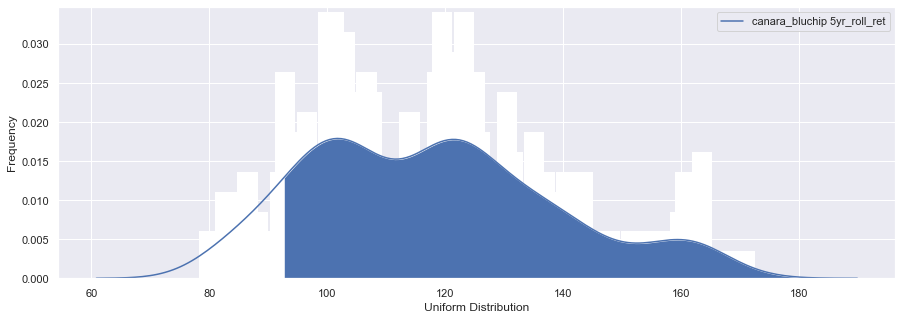

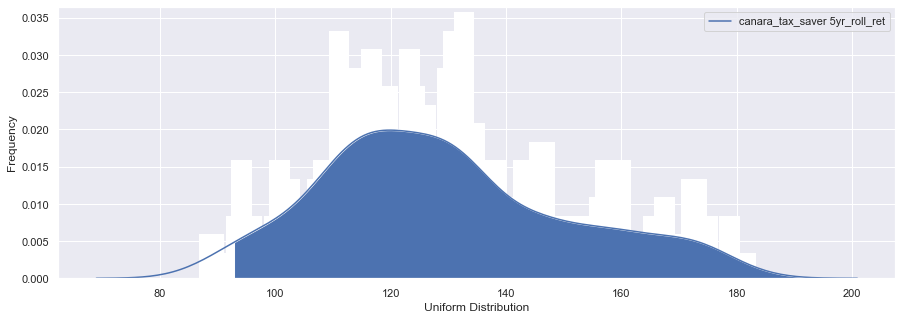

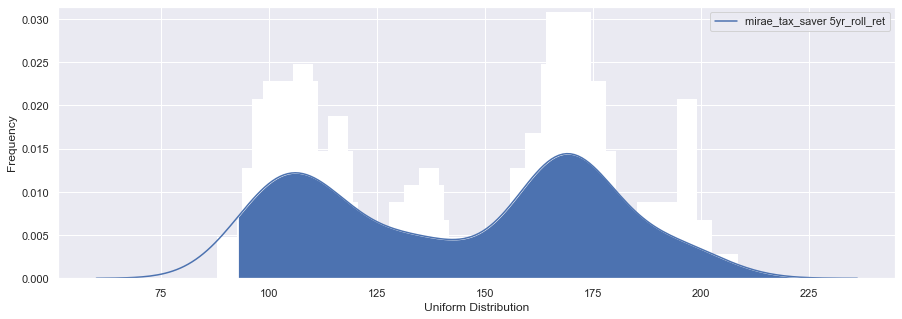

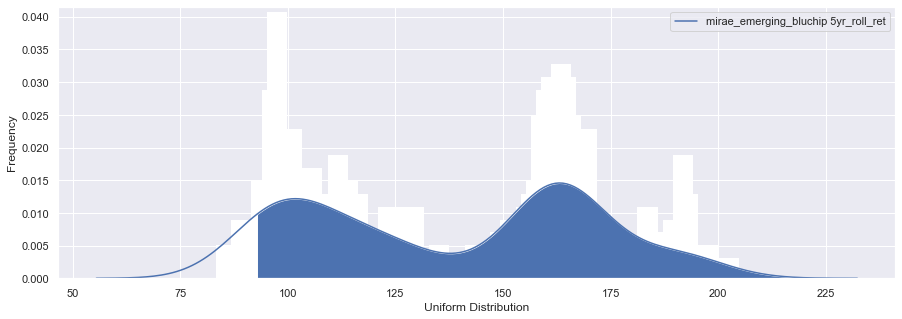

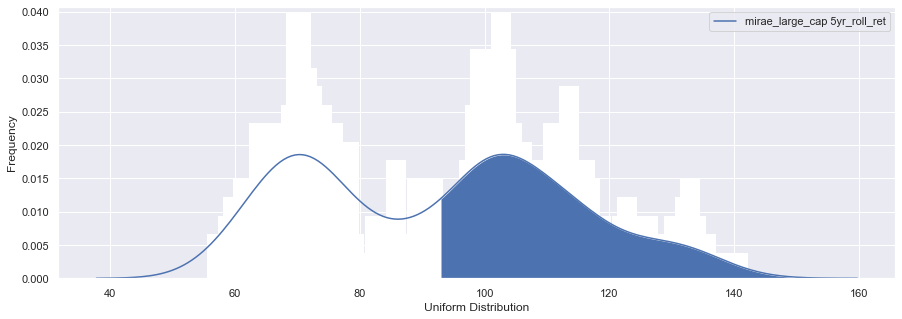

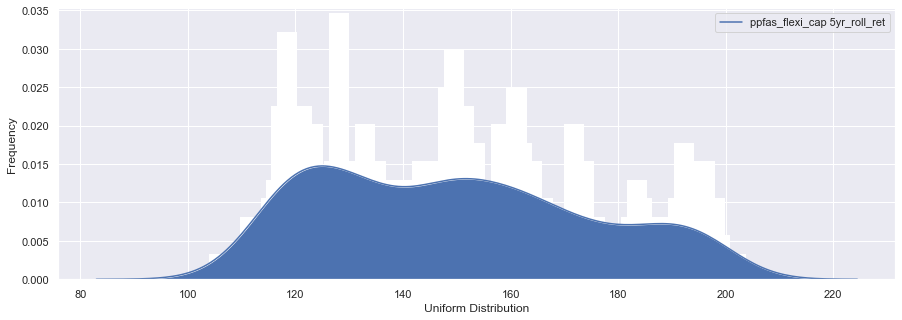

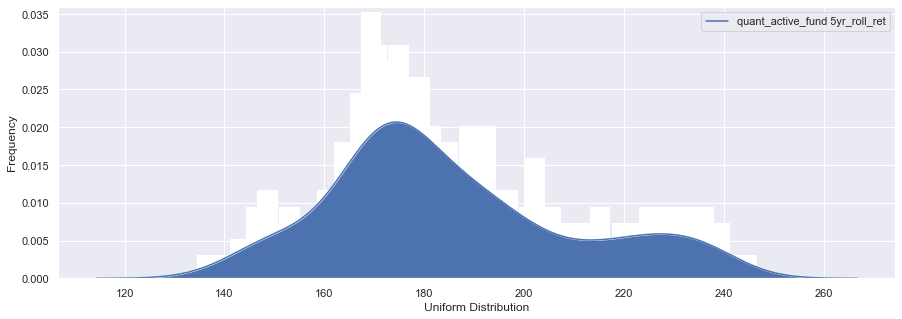

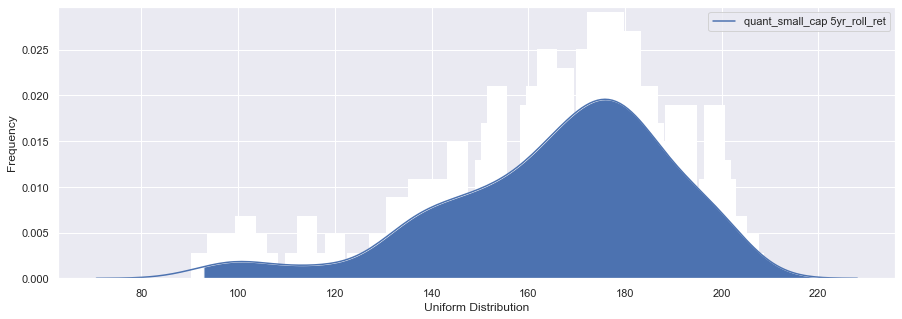

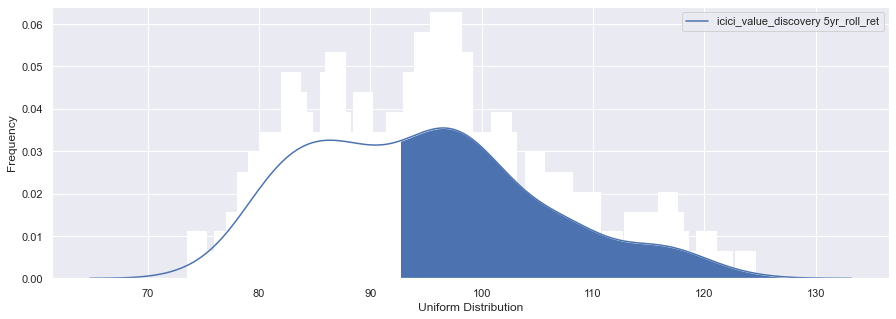

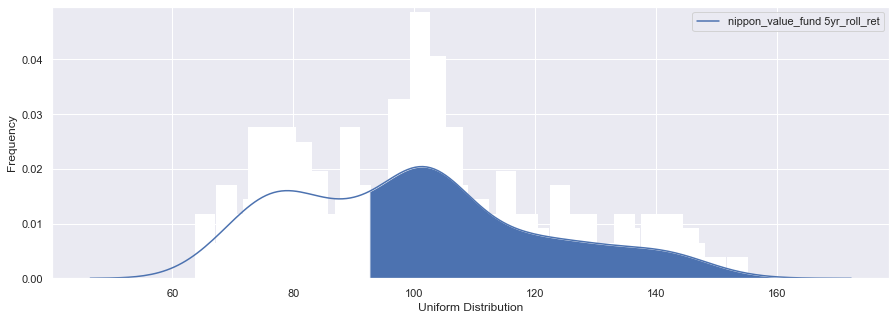

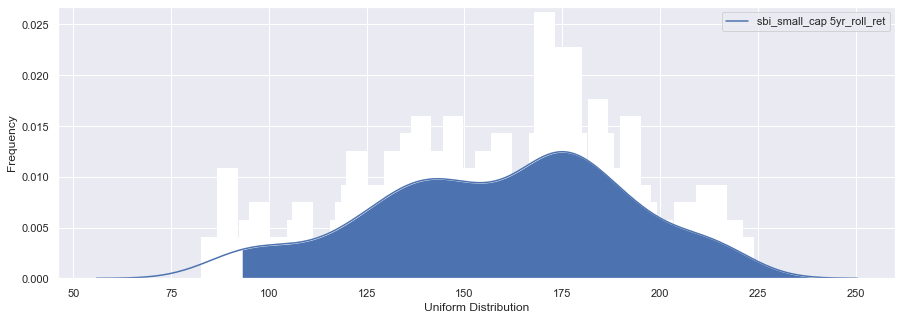

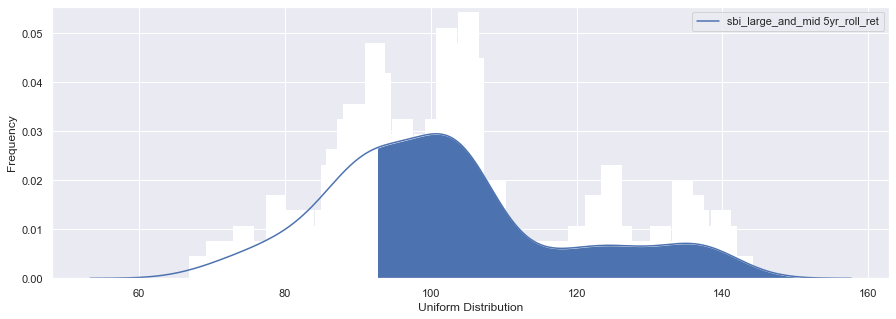

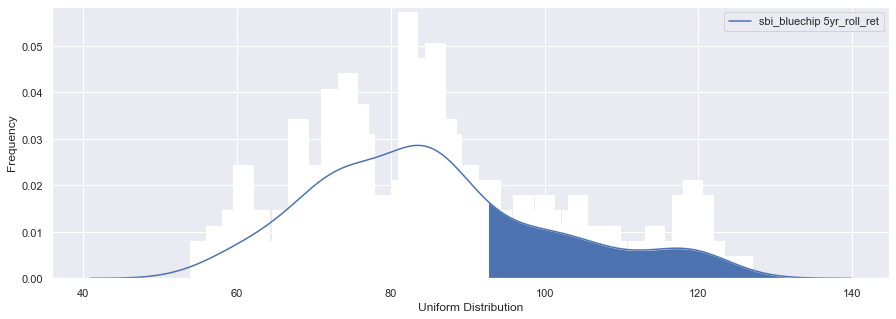

In [25]:
for idx, ret in enumerate(durations):
    for fund, mfID in fund_id_map.items():
        funds=[]
        for scheme ,scID in fund_scheme_map[fund].items():        
            fig = plt.figure(figsize=(15, 5))
            ax = sns.distplot(final_df[ (final_df['fund'] == scheme) & (final_df['date'] >= dates[idx]) ][ret],
                              bins=100,
                              kde=True,                          
                              hist_kws={"linewidth": 15,'alpha':1})

            kde_lines = ax.get_lines()[-1]
            kde_x, kde_y = kde_lines.get_data()            
            
            mask = ( kde_x > desired_rates[idx] )
            filled_x, filled_y = kde_x[mask], kde_y[mask]
            ax.fill_between(filled_x, y1=filled_y)
            area = np.trapz(filled_y, filled_x)

            print(f"Probability of return greater than risk free: {scheme} : {ret} : {area.round(2)}")

            funds.append(scheme)  
            ax.set(xlabel='Uniform Distribution', ylabel='Frequency')
            plt.legend(labels=[f"{scheme} {ret}"])
            # plt.axvline(x=0, linewidth=3, color='red', linestyle='--')
        

plt.show()

In [83]:
# for fund, mfID in fund_id_map.items():
#     for scheme ,scID in fund_scheme_map[fund].items():

pd.qcut(final_df[ (final_df['fund'] == 'ppfas_flexi_cap') & (final_df['date'] > '04-01-2019') ]['3yr_roll_ret'], q=7).value_counts()
pd.cut(final_df[ (final_df['fund'] == 'ppfas_flexi_cap') & (final_df['date'] > '04-01-2019') ]['3yr_roll_ret'], bins=7).value_counts()

(1.562, 33.589]       140
(49.08, 72.615]       140
(100.919, 134.375]    140
(33.589, 44.623]      139
(44.623, 49.08]       139
(72.615, 87.384]      139
(87.384, 100.919]     139
Name: 3yr_roll_ret, dtype: int64

(39.509, 58.482]      298
(77.455, 96.428]      191
(20.536, 39.509]      133
(58.482, 77.455]       98
(96.428, 115.401]      98
(115.401, 134.375]     86
(1.43, 20.536]         72
Name: 3yr_roll_ret, dtype: int64

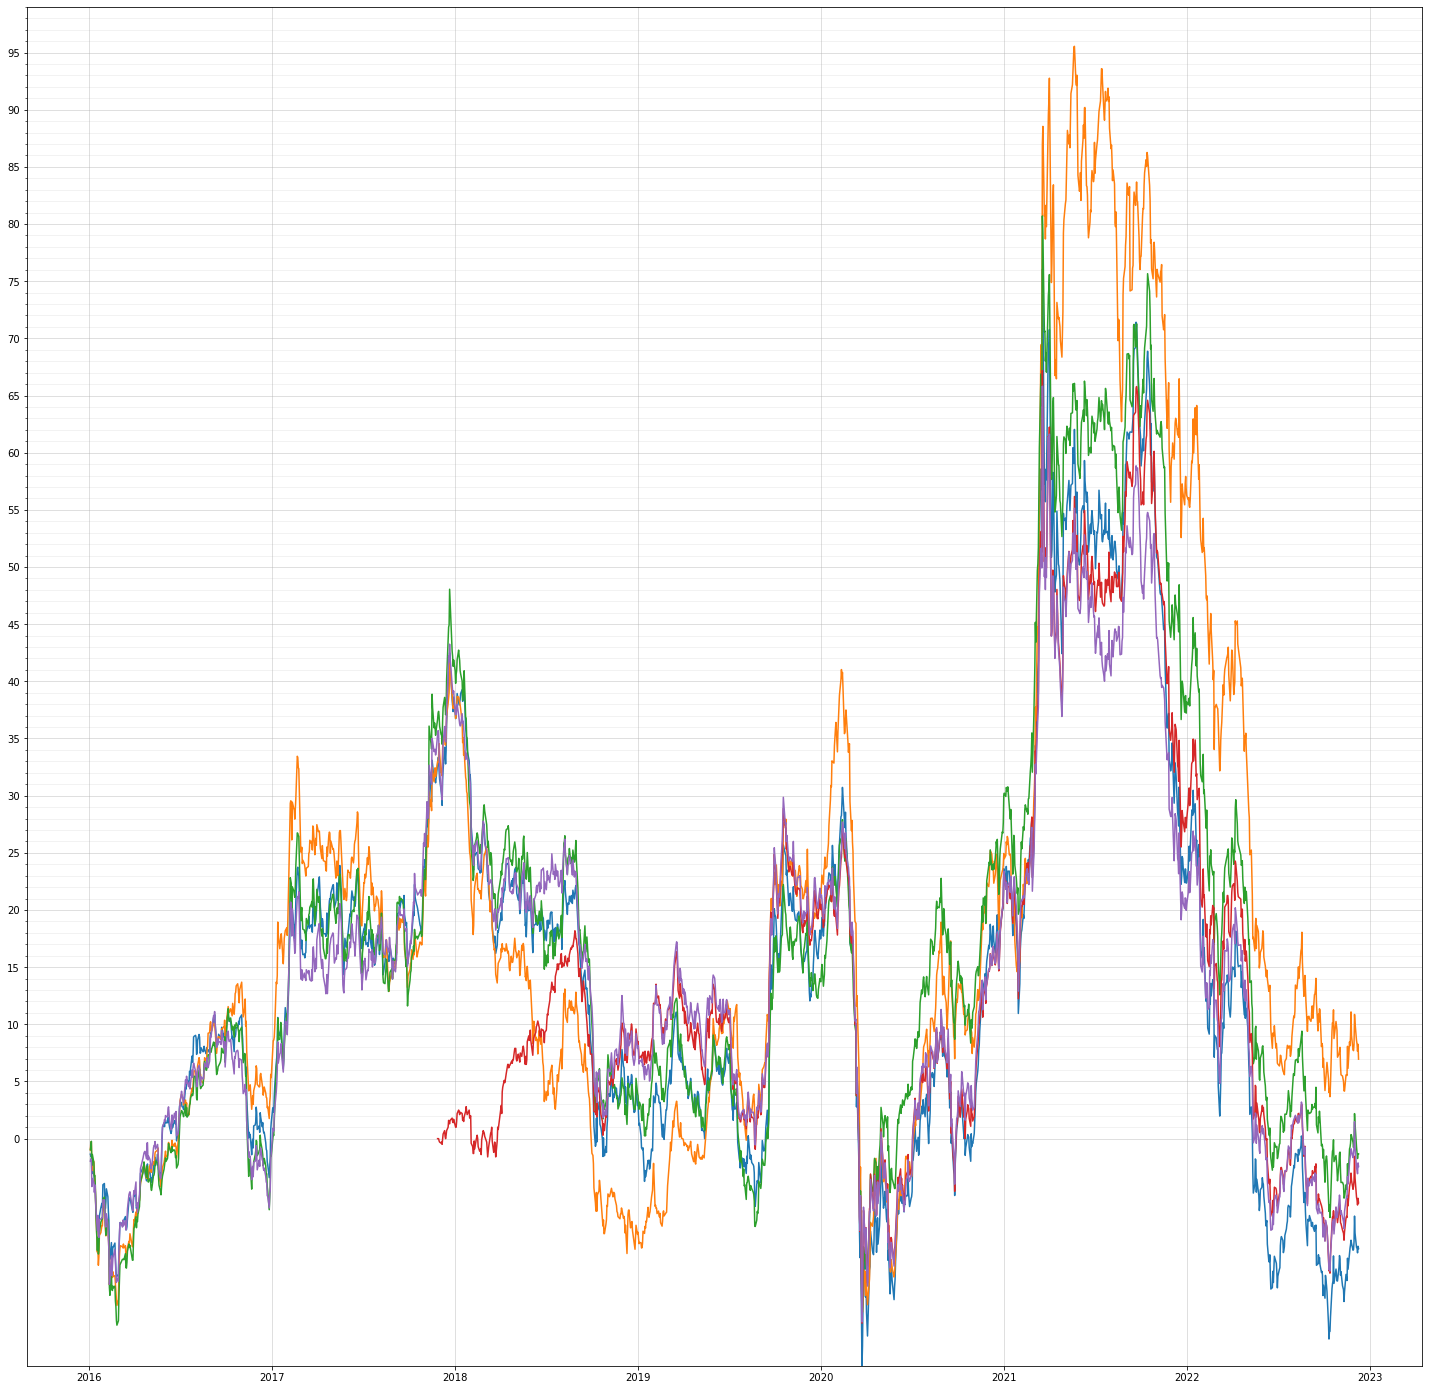

In [135]:

pdf = final_df


fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1)
plt.ylim(pdf["1yr_roll_ret"].min(), pdf["1yr_roll_ret"].max())
major_ticks = np.arange(0, 100, 5)
minor_ticks = np.arange(0, 100, 1)

# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():

        plt.plot(
            pdf[pdf['fund']==scheme].index,
            pdf[pdf['fund']==scheme]["1yr_roll_ret"]
        )


# plt.plot(
#     pdf.iloc[246:].index,
#     pdf.iloc[246:]["2yr_roll_ret"]
# )

# plt.plot(
#     pdf.iloc[492:].index,
#     pdf.iloc[492:]["3yr_roll_ret"]
# )


# plt.axhline(y = pdf["1yr_roll_ret"].mean())
# plt.axhline(y = pdf.iloc[246:]["2yr_roll_ret"].mean())
# plt.axhline(y = 0)


# plt.plot(
#     pdf.index,
#     pdf["cum_return"]
# )


plt.show()

In [37]:
## https://www.hdfcpension.com/nav/nav-history/

import random
import string

nps_start_dt = date(2016, 8, 1)
nps_end_dt = date.today()
char_set = string.ascii_uppercase + string.digits
#nonce = ''.join(random.sample(char_set*10, 10))
    
def fetch_nps():
    nps_url = 'https://www.hdfcpension.com/wp-admin/admin-ajax.php'
    
    nps_data = {
      'action': 'nav_get',
      'nonce': 'ab08f277c5',
      'from_date': nps_start_dt.strftime('%Y-%m-%d'),
      'to_date': nps_end_dt.strftime('%Y-%m-%d'),
    }

    return re.post(url = nps_url, data =nps_data)
    
nps_res = fetch_nps()
soup = BeautifulSoup(nps_res.content)
print(soup.get_text())
#print(soup.find_all('tr'))



    


{"success":true,"data":"\n          \n            \n           \n           \n\n            Date<\/th>\n            HDFC Pension Fund Scheme Tier I<\/th>\n            HDFC Pension Fund Scheme Tier II<\/th>\n\t    NPS LITE SCHEME <\/th>\n            <\/tr>\n\n                \n                     <\/th>\n                     E<\/th>\n                     C<\/th>\n                     G<\/th>\n                     A<\/th>\n                     E<\/th>\n                     C<\/th>\n                     G<\/th>\n                     A<\/th>\n                     TAX SAVER SCHEME<\/th>\n\t\t    <\/th>\n                <\/tr>\n      \n                     \n                             \n                          01-08-2016<\/td>\n                          16.161<\/td>\n                          14.1912<\/td>\n                          14.2926<\/td>\n                           - <\/td>\n                          13.9543<\/td>\n                          13.3488<\/td>\n                     